<a href="https://colab.research.google.com/github/Viggofudail/Project-A-Kelompok-3-PBA-GASAL-2025-2026/blob/main/PBA_MitraDarat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Acquisition



In [ ]:
!pip install feedparser pandas datetime urllib3 sastrawi newspaper3k lxml_html_clean requests_html feedparser requests beautifulsoup4 newspaper3k openpyxl

## Scrape Link Berita

Sheets berisi Link asli berita (bukan redirect dari google news, sehingga harus didownload dulu pada link berikut) : https://docs.google.com/spreadsheets/d/1y-0uxDuZfzFd6bABieboryQ-nXHvE7Xq1WI0gMWurJM/edit?usp=sharing

In [ ]:
import feedparser
import pandas as pd
from datetime import datetime
from urllib.parse import quote
import requests
from bs4 import BeautifulSoup
from newspaper import Article
from urllib.parse import urlparse

def scrape_google_news(keyword):
    # Encode keyword biar aman di URL
    encoded_keyword = quote(keyword)
    rss_url = f"https://news.google.com/rss/search?q={encoded_keyword}&hl=id&gl=ID&ceid=ID:id"

    feed = feedparser.parse(rss_url)

    data = []
    for entry in feed.entries:
        data.append({
            "title": entry.title,
            "link": entry.link,
            "published": entry.published if "published" in entry else None,
            "source": entry.source.title if "source" in entry else None
        })

    return data

if __name__ == "__main__":
    keyword = '"Mitra Darat"'   # gunakan frasa dengan kutip
    news_data = scrape_google_news(keyword)

    df = pd.DataFrame(news_data)
    print(df)

    if not df.empty:
        filename = f"news_mitradarat_{datetime.now().strftime('%Y%m%d')}.csv"
        df.to_csv(filename, index=False, encoding="utf-8-sig")
        print(f"Data berhasil disimpan di {filename}")
    else:
        print("Tidak ada berita ditemukan.")


                                                title  \
0   Ingin Ikut Mudik Gratis 2025? Ini Syarat dan C...   
1   Cara Daftar Mudik Gratis Kemenhub 2025 melalui...   
2   Ingin Mudik Gratis? Berikut Kota Tujuan dan Ja...   
3   Pengguna bisa cek pergerakan Trans Metro Dewat...   
4   Cara Mendaftar Mudik Gratis 2024 dan Rincian K...   
..                                                ...   
95  Bisa dengan Bus & Kereta Api, Ini Cara Daftar ...   
96  Program Mudik Gratis Ditjen Hubdat! Berikut Ca...   
97  Kemenhub Tingkatkan Digitalisasi Layanan Darat...   
98  Kapan Pendaftaran Motis Lebaran 2024 Dibuka, K...   
99  Cara Naik Trans Metro Dewata Bali, dari Bandar...   

                                                 link  \
0   https://news.google.com/rss/articles/CBMidkFVX...   
1   https://news.google.com/rss/articles/CBMitwFBV...   
2   https://news.google.com/rss/articles/CBMiqAFBV...   
3   https://news.google.com/rss/articles/CBMipwFBV...   
4   https://news.google.com/rs

## Scrape isi berita

Mengambil data dari csv Kelompok 3 - Link Berita MitraDarat yang telah berisi link berita langsung dari sumber bukan redirect.

In [ ]:
def scrape_article(url):
    try:
        # Gunakan newspaper3k lebih dulu
        article = Article(url, language="id")
        article.download()
        article.parse()
        return article.title, article.text
    except:
        try:
            # Fallback pakai BeautifulSoup
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.text, "html.parser")

            # Judul
            title = soup.find("title").get_text(strip=True) if soup.find("title") else None

            # Konten
            paragraphs = soup.find_all("p")
            text = " ".join([p.get_text() for p in paragraphs])
            return title, text.strip()
        except:
            return None, None

if __name__ == "__main__":
    # Baca file Excel (input link berita)
    df = pd.read_excel("Kelompok 3 - Link Berita MitraDarat.xlsx")

    required_cols = ["PIC", "URL", "URL [Direct]", "Published"]
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"File harus memiliki kolom: {required_cols}")

    titles, contents, sources = [], [], []

    for link in df["URL [Direct]"]:
        title, content = scrape_article(link)
        titles.append(title)
        contents.append(content)

        try:
            domain = urlparse(link).netloc
        except:
            domain = None
        sources.append(domain)

    # Buat dataframe hasil scraping
    scraped_df = pd.DataFrame({
        "title": titles,
        "link": df["URL [Direct]"],
        "published": df["Published"],
        "source": sources,
        "content_raw": contents
    })

    # Simpan hasil scraping (tanpa preprocessing dulu)
    output_file = "news_mitradarat_scraped.csv"
    scraped_df.to_csv(output_file, index=False, encoding="utf-8-sig")

    print(f"✅ Data hasil scraping disimpan ke {output_file} (total: {len(scraped_df)})")

✅ Data hasil scraping disimpan ke news_mitradarat_scraped.csv (total: 174)


# Data Preprocessing

In [ ]:
from bs4 import BeautifulSoup
from newspaper import Article
import nltk
import re
from urllib.parse import urlparse
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


# Download resource NLTK (sekali saja)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")

# ============== PREPROCESSING ==============
def preprocess_text(text):
    if not text or not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Hapus karakter non-alfabet
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Tokenizing
    tokens = nltk.word_tokenize(text)

    # Stopwords removal (Indonesian + English)
    stop_words = set(stopwords.words("indonesian") + stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Stemming (Sastrawi untuk bahasa Indonesia)
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

# ============== MAIN ==============
if __name__ == "__main__":
    # Baca hasil scraping
    df = pd.read_csv("news_mitradarat_scraped.csv")

    # Preprocessing isi berita
    df["content_clean"] = df["content_raw"].apply(preprocess_text)

    # Simpan hasil akhir
    output_file = "news_mitradarat_preprocessed.csv"
    df.to_csv(output_file, index=False, encoding="utf-8-sig")

    print(f"✅ Data hasil preprocessing disimpan ke {output_file} (total: {len(df)})")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Data hasil preprocessing disimpan ke news_mitradarat_preprocessed.csv (total: 174)


## Before & after Stopword removal

In [ ]:
def get_tokens_before_after(text):
    if not text or not isinstance(text, str):
        return [], []

    # Lowercase dan hapus karakter non-alfabet
    text_clean = re.sub(r"[^a-zA-Z\s]", " ", text.lower())

    # Tokenizing
    tokens = nltk.word_tokenize(text_clean)
    tokens_before_stopwords = tokens.copy()

    # Stopwords removal
    stop_words = set(stopwords.words("indonesian") + stopwords.words("english"))
    tokens_after_stopwords = [word for word in tokens if word not in stop_words and len(word) > 2]

    return tokens_before_stopwords, tokens_after_stopwords

# Terapkan ke DataFrame
df["tokens_before_stopwords"], df["tokens_after_stopwords"] = zip(*df["content_raw"].apply(get_tokens_before_after))

print(f"\nSebelum Stopword")
print (df["tokens_before_stopwords"].head(10))

print(f"\nSetelah Stopword")
print (df["tokens_after_stopwords"].head(10))



Sebelum Stopword
0                                                   []
1    [sorry, the, page, you, were, looking, for, ca...
2    [mudik, kerap, kali, menjadi, beban, bagi, par...
3                                                   []
4                                                   []
5    [denpasar, antara, dinas, perhubungan, dishub,...
6    [syarat, dan, cara, daftar, mudik, gratis, kem...
7                                                   []
8                                                   []
9    [kompas, com, kementerian, badan, usaha, milik...
Name: tokens_before_stopwords, dtype: object

Setelah Stopword
0                                                   []
1    [sorry, page, looking, found, try, searching, ...
2    [mudik, kerap, kali, beban, perantau, kota, pr...
3                                                   []
4                                                   []
5    [denpasar, dinas, perhubungan, dishub, bali, m...
6    [syarat, daftar, mudik, gratis, ke

## Frequent 100 Kata

In [ ]:
from collections import Counter

# Ambil semua token setelah stopwords
all_tokens = [token for sublist in df["tokens_after_stopwords"] for token in sublist]

# Hitung frekuensi dan ambil top 100
top_100_words = Counter(all_tokens).most_common(100)

# Tampilkan hasil
print(" Top 100 kata paling sering muncul:")
for word, freq in top_100_words:
    print(f"{word}: {freq}")


 Top 100 kata paling sering muncul:
mudik: 1289
gratis: 848
kemenhub: 476
peserta: 428
pendaftaran: 421
bus: 418
darat: 372
aplikasi: 357
motor: 330
program: 302
arus: 282
kota: 279
keberangkatan: 273
perhubungan: 266
jakarta: 260
sepeda: 254
tujuan: 213
terminal: 213
masyarakat: 194
ulang: 184
kuota: 181
tiket: 173
mitradarat: 173
mitra: 166
tanggal: 145
lebaran: 144
validasi: 144
kementerian: 143
posko: 143
wajib: 143
daftar: 143
maret: 143
pemudik: 133
april: 129
registrasi: 127
penumpang: 125
mendaftar: 123
baca: 122
transportasi: 121
online: 120
angkutan: 118
syarat: 117
kendaraan: 115
akun: 110
data: 105
pilih: 104
dibuka: 104
ditjen: 99
truk: 98
tangerang: 98
jadwal: 97
ditentukan: 93
solo: 92
kereta: 91
sesuai: 90
wib: 90
yogyakarta: 90
moda: 88
layanan: 86
lokasi: 84
calon: 83
semarang: 82
informasi: 81
api: 80
laut: 78
perjalanan: 77
klik: 76
jawa: 76
jalur: 76
kampung: 74
hubdat: 72
orang: 71
mengikuti: 70
jenderal: 70
membawa: 69
memiliki: 66
nomor: 66
purwokerto: 66
unit: 

## Top 100 wordcloud

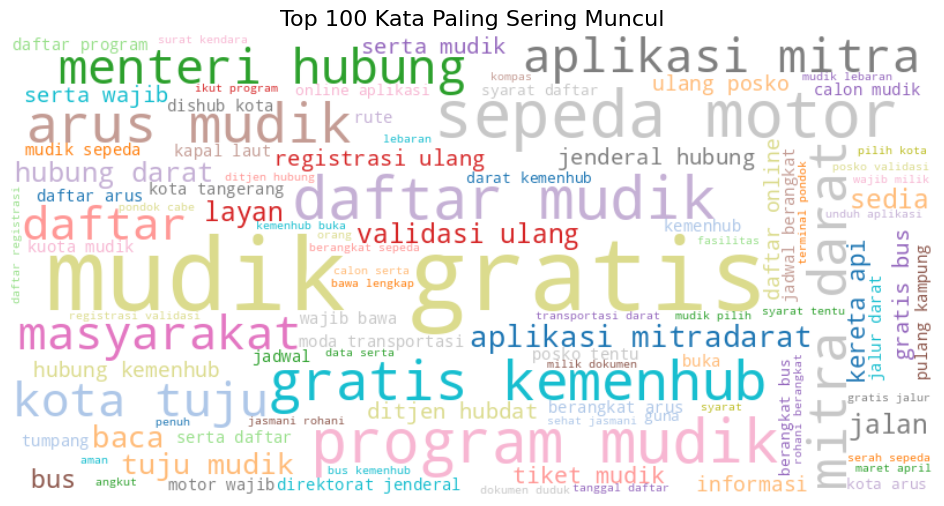

In [ ]:
# Install package jika belum ada
# !pip install wordcloud matplotlib

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ambil semua teks yang sudah dibersihkan
text = " ".join(df["content_clean"].astype(str).tolist())

# Buat word cloud berbentuk kotak
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white',
                      colormap='tab20',
                      max_words=100,
                      contour_color='black',
                      contour_width=1).generate(text)

# Tampilkan
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top 100 Kata Paling Sering Muncul", fontsize=16)
plt.show()


# TF - IDF + top kata



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Hapus dokumen kosong atau hanya spasi
df = df[df["content_clean"].str.strip() != ""]

# Pastikan index reset agar tidak loncat
df = df.reset_index(drop=True)

# Pastikan df["content_clean"] sudah ada
documents = df["content_clean"].astype(str).tolist()

output_file = "news_mitradarat_preprocessed2.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

# Buat TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000,  # jumlah kata teratas
                             ngram_range=(1,1),   # unigram
                             stop_words=None)     # stopwords sudah dibersihkan sebelumnya

# Fit & transform
tfidf_matrix = vectorizer.fit_transform(documents)

# Konversi ke DataFrame agar lebih mudah dianalisis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Lihat TF-IDF top 10 kata untuk dokumen pertama
top_n = 10
top_words_doc1 = tfidf_df.iloc[0].sort_values(ascending=False).head(top_n)
print("Top 10 kata TF-IDF untuk dokumen pertama:")
print(top_words_doc1)

# Opsional: TF-IDF rata-rata per kata di seluruh dokumen
mean_tfidf = tfidf_df.mean().sort_values(ascending=False).head(20)
print("\nTop 20 kata TF-IDF rata-rata di seluruh dokumen:")
print(mean_tfidf)

# Cek baris dengan TF-IDF = 0 semua
mask_zero = (tfidf_df.sum(axis=1) == 0)

# Simpan hanya dokumen yang punya bobot
tfidf_nonzero = tfidf_df[~mask_zero]

# Bisa juga kalau mau tahu indeks yang di-skip
skipped_docs = df.index[mask_zero].tolist()
print("Dokumen yang di-skip:", skipped_docs)



Top 10 kata TF-IDF untuk dokumen pertama:
fakultas        0.487651
hukum           0.449087
umsu            0.292591
universitas     0.292591
muhammadiyah    0.243826
laksana         0.234202
september       0.195060
kuliah          0.195060
utara           0.191580
sumatera        0.170463
Name: 0, dtype: float64

Top 20 kata TF-IDF rata-rata di seluruh dokumen:
mudik         0.224369
gratis        0.137145
daftar        0.121299
permission    0.109228
request       0.109228
serta         0.081220
kemenhub      0.075575
bus           0.068088
aplikasi      0.057982
motor         0.055206
darat         0.054321
program       0.054205
jakarta       0.051793
arus          0.050442
berangkat     0.048795
kota          0.048471
terminal      0.047469
sepeda        0.045065
hubung        0.041894
tiket         0.041099
dtype: float64
Dokumen yang di-skip: []


# Distribusi publikasi Artikel Berita

                       published            published_date month_abbr  quarter
0  Fri, 07 Mar 2025 03:42:41 GMT 2025-03-07 03:42:41+00:00        Mar        1
1  Thu, 13 Feb 2025 08:00:00 GMT 2025-02-13 08:00:00+00:00        Feb        1
2  Thu, 17 Apr 2025 07:00:00 GMT 2025-04-17 07:00:00+00:00        Apr        2
3  Wed, 19 Feb 2025 08:00:00 GMT 2025-02-19 08:00:00+00:00        Feb        1
4  Tue, 11 Mar 2025 07:00:00 GMT 2025-03-11 07:00:00+00:00        Mar        1


/tmp/ipython-input-3823197749.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index, y=month_counts.values, palette="crest")


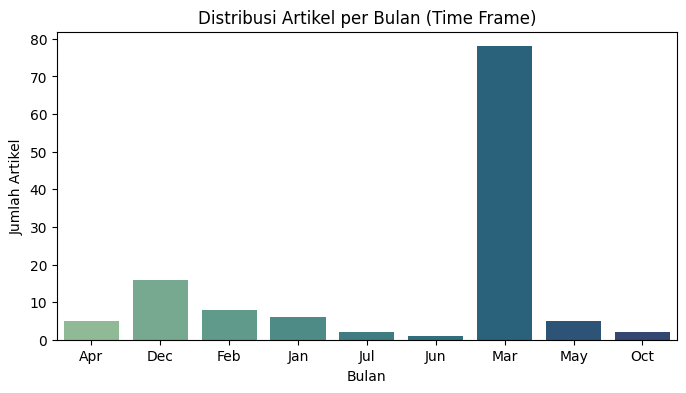

/tmp/ipython-input-3823197749.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Q{i}" for i in quarter_counts.index], y=quarter_counts.values, palette="viridis")


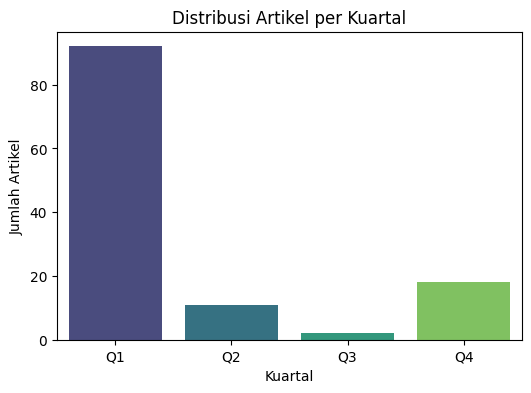

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Konversi string ke datetime
df["published_date"] = pd.to_datetime(df["published"], format="%a, %d %b %Y %H:%M:%S %Z", errors="coerce")

# Pisahkan komponen waktu
df["year"] = df["published_date"].dt.year
df["month"] = df["published_date"].dt.month_name()
df["month_abbr"] = df["published_date"].dt.strftime("%b")
df["quarter"] = df["published_date"].dt.quarter  # hasilnya angka 1–4 saja

# Cek hasil konversi
print(df[["published", "published_date", "month_abbr", "quarter"]].head())

# Distribusi artikel per bulan
month_counts = df["month_abbr"].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=month_counts.index, y=month_counts.values, palette="crest")
plt.title("Distribusi Artikel per Bulan (Time Frame)")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Artikel")
plt.show()

# Distribusi artikel per kuartal (tanpa tahun)
quarter_counts = df["quarter"].value_counts().sort_index()

plt.figure(figsize=(6,4))
sns.barplot(x=[f"Q{i}" for i in quarter_counts.index], y=quarter_counts.values, palette="viridis")
plt.title("Distribusi Artikel per Kuartal")
plt.xlabel("Kuartal")
plt.ylabel("Jumlah Artikel")
plt.show()


# POS

In [ ]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 25.9 MB/s eta 0:00:00


In [ ]:
import stanza
from collections import Counter

# Unduh model bahasa Indonesia
stanza.download("id")

# Muat pipeline
nlp = stanza.Pipeline("id", processors="tokenize,pos")

pos_counts = Counter()
for doc in nlp(df["content_raw"].str.cat(sep="\n")).sentences:
    for word in doc.words:
        pos_counts[word.upos] += 1

print("\nDistribusi POS (Stanza):")
print(pd.Series(pos_counts).sort_values(ascending=False))


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: id (Indonesian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/id/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: id (Indonesian):
| Processor | Package    |
--------------------------
| tokenize  | gsd        |
| mwt       | gsd        |
| pos       | gsd_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!



Distribusi POS (Stanza):
NOUN     20925
ADJ       2026
PROPN     1036
VERB      1015
X          451
CCONJ      435
ADP        132
ADV        116
NUM         54
PRON        21
AUX         18
PART         9
DET          4
dtype: int64


/tmp/ipython-input-3664762549.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="POS", x="Count", data=pos_df, palette="viridis")


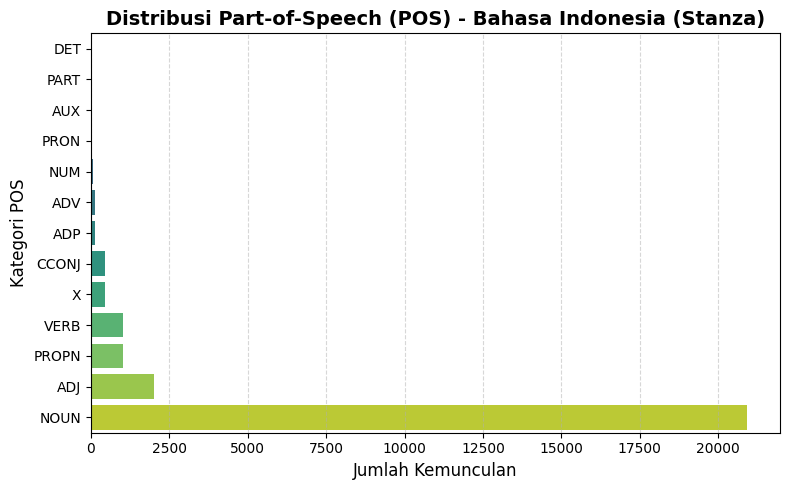

In [ ]:
pos_df = pd.DataFrame.from_dict(pos_counts, orient="index", columns=["Count"]).reset_index()
pos_df = pos_df.rename(columns={"index": "POS"}).sort_values("Count", ascending=True)

# Plot sidebar chart (horizontal bar chart)
plt.figure(figsize=(8, 5))
sns.barplot(y="POS", x="Count", data=pos_df, palette="viridis")

plt.title("Distribusi Part-of-Speech (POS) - Bahasa Indonesia (Stanza)", fontsize=14, weight="bold")
plt.xlabel("Jumlah Kemunculan", fontsize=12)
plt.ylabel("Kategori POS", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
!pip install spacy
!python -m spacy download xx_ent_wiki_sm

In [ ]:
import spacy
import pandas as pd

# Muat model multilingual
nlp = spacy.load("xx_ent_wiki_sm")

entities = []
for text in df["content_raw"].astype(str):
    doc = nlp(text)
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))

ner_df = pd.DataFrame(entities, columns=["Entity", "Label"])
print(ner_df["Label"].value_counts().head(10))


Label
PER     3438
LOC     1709
MISC    1133
ORG      638
Name: count, dtype: int64


# NER

/tmp/ipython-input-3350022676.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


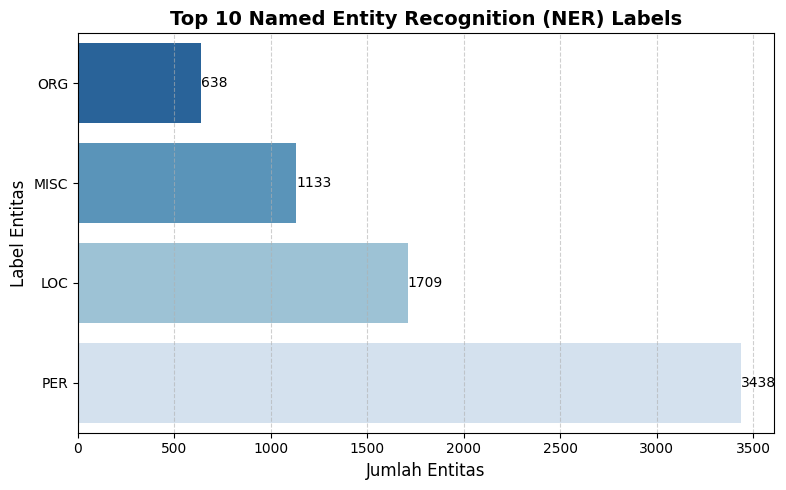

In [ ]:
# Hitung jumlah entitas per label
label_counts = ner_df["Label"].value_counts().head(10).sort_values(ascending=True)

# Buat sidebar chart (horizontal bar chart)
plt.figure(figsize=(8, 5))
sns.barplot(
    x=label_counts.values,
    y=label_counts.index,
    palette="Blues_r"
)

plt.title("Top 10 Named Entity Recognition (NER) Labels", fontsize=14, weight='bold')
plt.xlabel("Jumlah Entitas", fontsize=12)
plt.ylabel("Label Entitas", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Tampilkan nilai di ujung bar
for i, v in enumerate(label_counts.values):
    plt.text(v + 0.5, i, str(v), color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipython-input-3460404658.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_entities.index, x=top_entities.values, palette="mako")


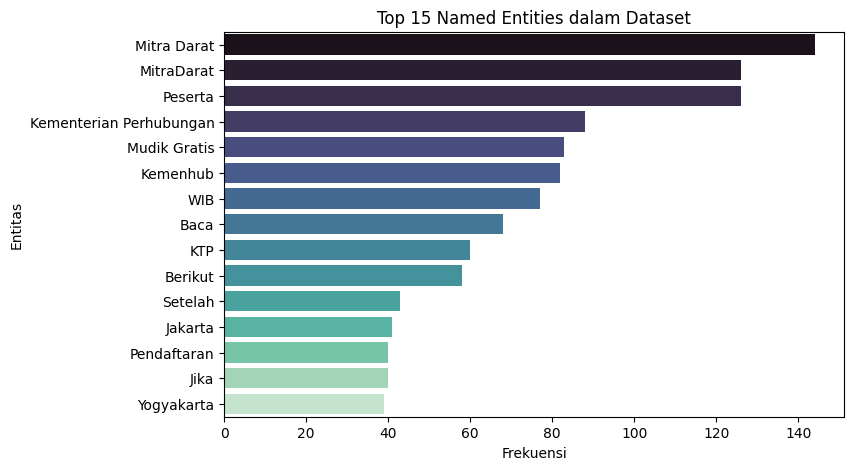

In [ ]:
top_entities = ner_df["Entity"].value_counts().head(15)
plt.figure(figsize=(8,5))
sns.barplot(y=top_entities.index, x=top_entities.values, palette="mako")
plt.title("Top 15 Named Entities dalam Dataset")
plt.xlabel("Frekuensi")
plt.ylabel("Entitas")
plt.show()


# Analisis Sentimen

In [ ]:
# Install TextBlob jika belum ada
# !pip install textblob

from textblob import TextBlob

# Fungsi analisis sentimen sederhana
def get_sentiment(text):
    if not text or not isinstance(text, str):
        return 0  # netral
    blob = TextBlob(text)
    return blob.sentiment.polarity  # -1 negatif, 0 netral, +1 positif

# Terapkan ke DataFrame
df['sentiment_score'] = df['content_clean'].apply(get_sentiment)

# Tentukan label berdasarkan skor
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x>0 else ('negative' if x<0 else 'neutral'))

print(df[['content_clean', 'sentiment_score', 'sentiment_label']].head())


                                       content_clean  sentiment_score  \
0  sorry page looking found try searching best ma...             0.10   
1  mudik kerap kali beban rantau kota program mud...            -0.05   
2  denpasar dinas hubung dishub bal arah guna lay...             0.00   
3  syarat daftar mudik gratis kemenhub aplikasi m...             0.00   
4  kompas com menteri badan usaha milik negara bu...             0.00   

  sentiment_label  
0        positive  
1        negative  
2         neutral  
3         neutral  
4         neutral  


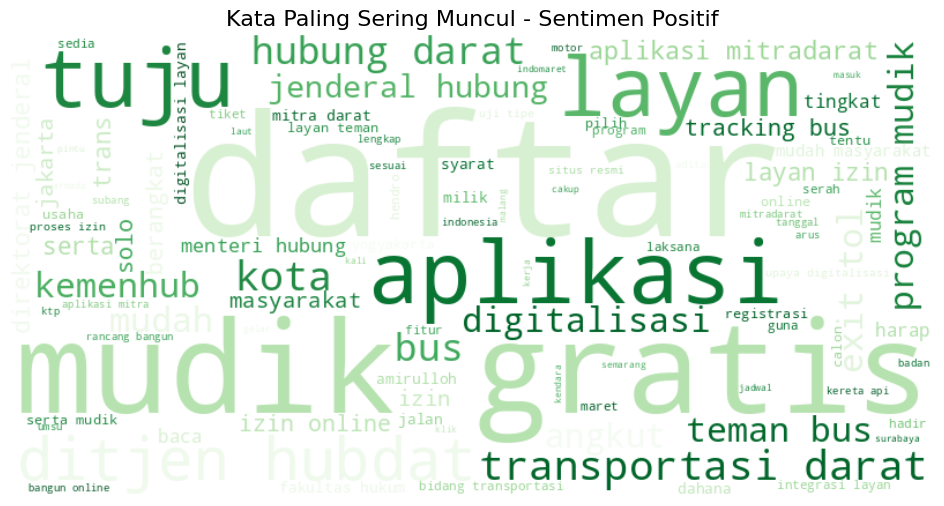

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ambil semua teks positif
positive_text = " ".join(df[df['sentiment_label']=='positive']['content_clean'].astype(str).tolist())

# WordCloud positif
wordcloud_pos = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='Greens',
                          max_words=100).generate(positive_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Kata Paling Sering Muncul - Sentimen Positif", fontsize=16)
plt.show()


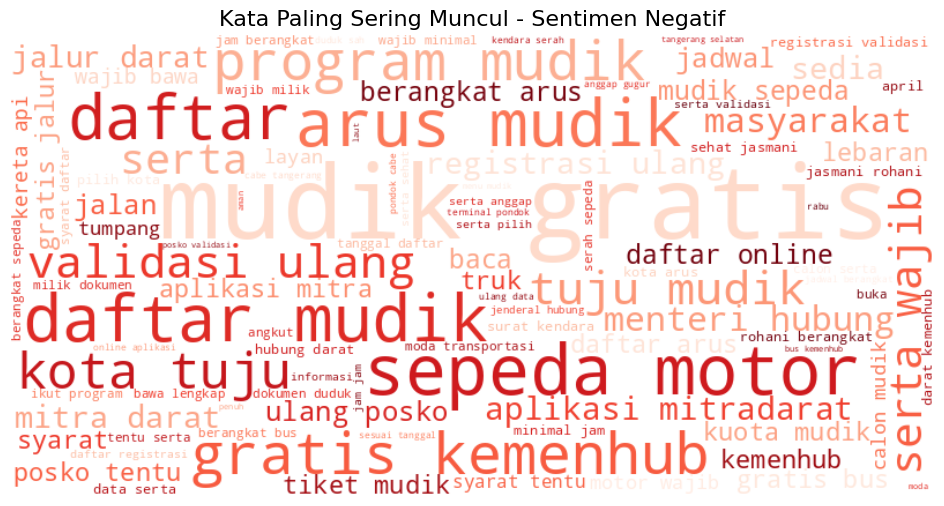

In [ ]:
# Ambil semua teks negatif
negative_text = " ".join(df[df['sentiment_label']=='negative']['content_clean'].astype(str).tolist())

# WordCloud negatif
wordcloud_neg = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='Reds',
                          max_words=100).generate(negative_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Kata Paling Sering Muncul - Sentimen Negatif", fontsize=16)
plt.show()


#Analisis Sentimen menggunakan SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_df,
    df["sentiment_label"],
    test_size=0.2,
    random_state=42,
    stratify=df["sentiment_label"]
)

In [ ]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

LinearSVC()

In [ ]:
y_pred = svm_model.predict(X_test)

print("\n Evaluasi Model Linear SVM:")
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


 Evaluasi Model Linear SVM:
Akurasi: 0.88

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83         6
     neutral       0.89      0.94      0.91        17
    positive       1.00      0.50      0.67         2

    accuracy                           0.88        25
   macro avg       0.91      0.76      0.80        25
weighted avg       0.88      0.88      0.88        25



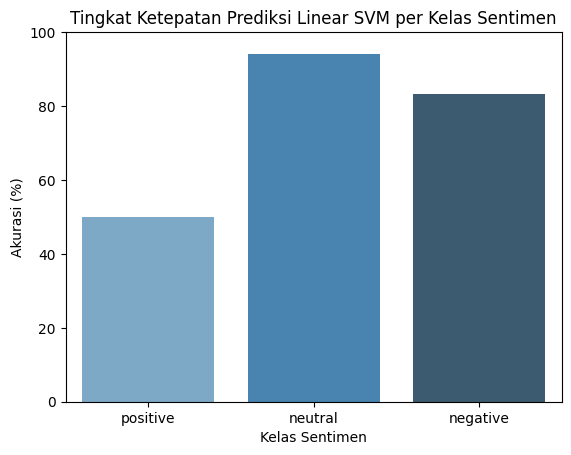

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Hitung confusion matrix
labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Ubah ke DataFrame agar mudah dibaca
cm_df = pd.DataFrame(cm, index=[f"Actual {l.capitalize()}" for l in labels],
                     columns=[f"Predicted {l.capitalize()}" for l in labels])

# Hitung akurasi per kelas
correct_per_class = cm.diagonal()
total_per_class = cm.sum(axis=1)
accuracy_per_class = (correct_per_class / total_per_class) * 100

# Buat dataframe untuk plot
acc_df = pd.DataFrame({
    "Sentiment": labels,
    "Accuracy (%)": accuracy_per_class
})

# Plot bar chart akurasi per kelas
sns.barplot(
    x="Sentiment",
    y="Accuracy (%)",
    hue="Sentiment",
    data=acc_df,
    palette="Blues_d",
    legend=False
)
plt.title("Tingkat Ketepatan Prediksi Linear SVM per Kelas Sentimen")
plt.ylim(0, 100)
plt.ylabel("Akurasi (%)")
plt.xlabel("Kelas Sentimen")
plt.show()

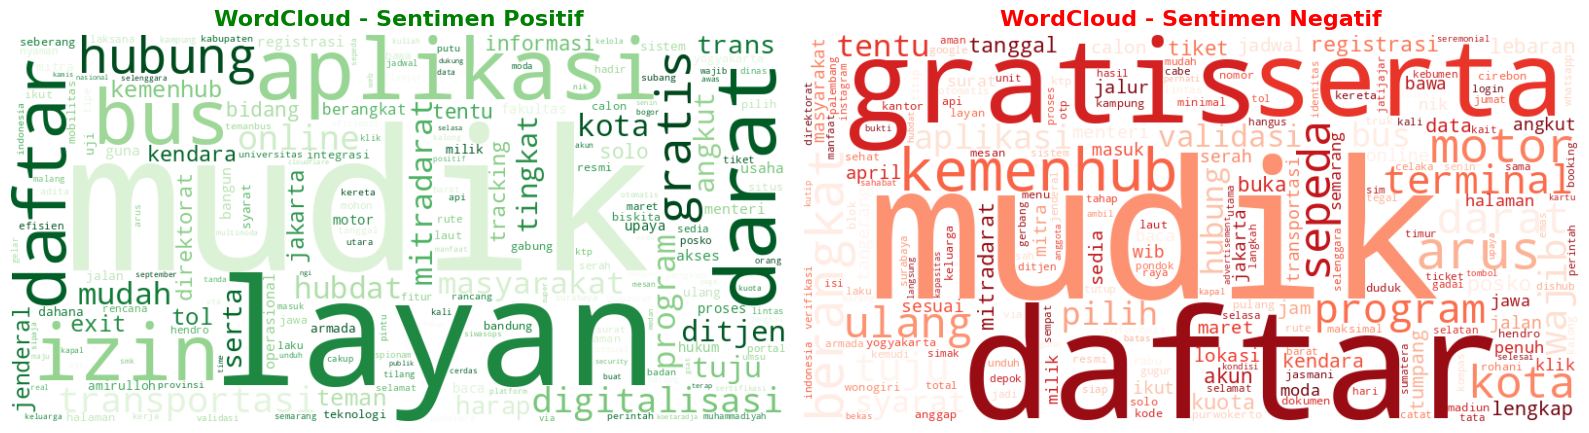

In [ ]:
# Pisahkan teks berdasarkan label sentimen
positive_text = " ".join(df[df["sentiment_label"] == "positive"]["content_clean"].astype(str))
negative_text = " ".join(df[df["sentiment_label"] == "negative"]["content_clean"].astype(str))

# Buat WordCloud untuk masing-masing
wc_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens', collocations=False).generate(positive_text)
wc_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds', collocations=False).generate(negative_text)

# Tampilkan hasilnya berdampingan
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Sentimen Positif", fontsize=16, fontweight='bold', color='green')

plt.subplot(1, 2, 2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Sentimen Negatif", fontsize=16, fontweight='bold', color='red')

plt.tight_layout()
plt.show()